# Alignment of 3k PBMCs against ELDB.v20221214 (320k subset) in AWS
v2023-11-15

This tutorial continues from **[Tutorial 1) Processing and analysis of the 3k PBMCs dataset using SC-Elephant](https://scelephant-free.s3.amazonaws.com/doc/SC-Elephant_PBMC3k_processing_and_analysis_tutorials.html)**

In [1]:
""" 
Reset the current tutorial
"""
# delete the output to reset the tutorials
!rm -rf output/pbmc3k.combined_with_eldb.v20221214.aws.subset_320000.ram/

In [2]:
"""
Import necessary packages
"""
# not use GPU (only inference will be performed, and using CPUs are sufficient)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# import scelephant
import scelephant as el
from scelephant import RamData
import scanpy as sc
# set figure parameters
sc.set_figure_params( dpi = 200, figsize = ( 8, 6 ), frameon = True )

# plotly export settings
import plotly.io as pio
pio.renderers.default = "notebook"

"""
configure the jupyter notebook environment
"""
el.bk.Wide( 100 ) # adjust the jupyter notebook cell width 

import matplotlib as mpl
mpl.rcParams[ "figure.dpi" ] = 100
# set image resolution

# load memory profiler 
# %load_ext memory_profiler

## **Initialize a Combined RamData - Connect PBMC-3k dataset to ELDB**
- JavaScript-based interactive visualization of 'Combined' RamData object in Jupyter Notebook

In [3]:
"""
Open a Combined RamData - combine ELDB and PBMC3k datasets
"""
# settings
""" [WARNING]
Changing 'flag_use_full_ELDB' to True will result in downloading
a large amount of data from a requester-pay bucket (s3://scelephant/).
On the other hand, RamData objects in s3://scelephant-free/ bucket is freely available. """
flag_use_full_ELDB = False 

# initialize a pool of managed operators
fop = el.managers.FileSystemOperatorPool( 8 ) # this pool of managed operators will be used throughout the tutorials

if flag_use_full_ELDB :
    ram_ref = RamData( 's3://scelephant/ELDB.combined_v20221214.ramdata/', file_system_operator_pool = fop, name_layer = None, flag_enable_synchronization_through_locking = False, ) # contain full ELDB data, but it is requester-pay bucket, and it is not FREE. 
else :
    ram_ref = RamData( 's3://scelephant-free/ELDB.combined_v20221214.subset_320000_barcodes.ramdata/', file_system_operator_pool = fop, name_layer = None, flag_enable_synchronization_through_locking = False, ) # does not contain full ELDB data (full dataset is a requester-pay bucket)

ram_query = RamData( f'output/pbmc3k.ram/', file_system_operator_pool = fop )

# build feature mapping using 'id_gene', not 'name_gene'
ram_ref.ft.int_index_str_rep = 0
ram_query.ft.int_index_str_rep = 0

ram = RamData(
    "output/pbmc3k.combined_with_eldb.v20221214.aws.subset_320000.ram/", # output path of the Combined RamData object
    l_ramdata = [ ram_ref, ram_query ], # list of RamData object to combine
    name_layer = None,
    int_total_weight_for_each_batch = 10_000_000,
    int_index_component_reference = 0, # the index of the RamData object to use as a reference (which will activate Reference Alignment mode)
    file_system_operator_pool = fop,
    flag_enable_synchronization_through_locking = False, # You can set it to False for better performance, but for RamData objects that are frequently updated, setting to True might be needed to avoid collisions
)

2023-11-18 21:26:58,728 [SC-Elephant] <INFO> (layer) - 'raw' layer has been loaded


## **View a Combined RamData**
- JavaScript-based interactive visualization of 'Combined' RamData object in Jupyter Notebook

In [4]:
ram

<RamData object (322700 barcodes X 62914 features) stored at /home/merit_an/git/scelephant/doc/jn/tutorials/output/pbmc3k.combined_with_eldb.v20221214.aws.subset_320000.ram/
	with the following layers : {'normalized', 'raw', 'normalized_log1p', 'normalized_log1p_capped'}
		current layer is 'None'>

## Calculate PCA values of the PBMC-3k dataset using a PCA model from ELDB

In [5]:
"""
Get PCA values of the new barcodes
"""
# settings of the pipeline
name_anno_ori = 'leiden_scanpy'
name_col_bc_all = 'filtered_barcodes' # name of the column containing filtered cells

name_model = 'ipca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp' # name of the PCA model of the ELDB
name_col_filter_ft = "filter_pca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp" # name of the filter containing genes for the PCA model
ram.ft.change_filter( name_col_filter_ft ) # select the features

# set the suffix of the run
str_suffix_new = '_aligned'
str_suffix = '_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp'
name_col_pca = f'X_pca{str_suffix}{str_suffix_new}' # new PCA column name that will contains PBMC 3k's PCA values, calculated with a iPCA model of the ELDB

"""
Get PCA values
"""
ram.bc.change_filter( name_col_bc_all ) # select filtered cells
model = ram.apply_pca( 
    name_model = name_model, 
    name_layer = 'normalized_log1p_capped', 
    name_col = name_col_pca, 
    int_n_components_in_a_chunk = 20, 
    int_num_threads = 5,
    int_index_component_reference = 0, # currently, index 0 contains the reference RamData, the ELDB (or a subset of ELDB).
)

2023-11-18 21:27:27,356 [aiobotocore.credentials] <INFO> (load) - Found credentials in shared credentials file: ~/.aws/credentials
2023-11-18 21:27:43,862 [SC-Elephant] <INFO> (layer) - loading a layer 'normalized_log1p_capped' of RamData component 0
2023-11-18 21:27:52,014 [SC-Elephant] <INFO> (layer) - 'normalized_log1p_capped' layer has been loaded
2023-11-18 21:27:52,016 [SC-Elephant] <INFO> (layer) - loading a layer 'normalized_log1p_capped' of RamData component 1
2023-11-18 21:27:52,108 [SC-Elephant] <INFO> (layer) - 'normalized_log1p_capped' layer has been loaded
2023-11-18 21:27:52,216 [SC-Elephant] <INFO> (layer) - 'normalized_log1p_capped' layer has been loaded
2023-11-18 21:28:02,258 [SC-Elephant] <INFO> (load_str) - completed loading of 10504 number of strings
2023-11-18 21:28:07,877 [SC-Elephant] <INFO> (load_str) - completed loading of 10504 number of strings
100 PCs from 10504 features: 100%|████████████████████████████████████████████████████████████████████████████████

## Embed the cells of the PBMC-3k dataset in the existing embeddings of ELDB, and retrieve neighboring cells from ELDB

In [6]:
"""
co-embedding of new barcodes
"""
str_num_subsampled_cells = "160000" if flag_use_full_ELDB else '20480000' # during embedding process, align the cells of interest to a subset of cells of the ELDB
name_model = f"knnindex__filtered_barcodes_subsampled_{str_num_subsampled_cells}_entries_clus_info__X_pca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp__100comp__30_neighbors" # kNN graph for embedding the cells of interest to ELDB
name_col_filter_bc_subsampled = f'filtered_barcodes_subsampled_{str_num_subsampled_cells}_entries_clus_info' # name of the column containing the filter of subsampled cells
name_umap = 'X_umap_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_filtered_barcodes_subsampled_18097526_entries_30knn100comp_scanpy_spectral' # name of the column containing UMAP coordinates
name_umap_combined = f'{name_umap}_combined' # the output column name that will contain the UMAP coordinates of the new cells

ram.bc.change_filter( name_col_filter_bc_subsampled )

ram.bc.meta[ name_umap_combined ] = ram.bc.meta[ name_umap ] # copy original values

# perform embedding, while retrieving primary & secondary neighbors
ram.bc.change_filter( name_col_bc_all )
ram.apply_knn(
    name_model,
    name_col_x = name_col_pca, 
    name_col_y_input = name_umap,
    name_col_y_output = name_umap_combined,
    axis = 'barcodes',
    operation = 'embedder',
    float_std_ratio_for_outlier_detection = 0.03,
    name_col_filter_neighbors_of_the_query = 'filter_barcodes_aligned',
    int_index_component_reference = 0,
)

# retrieve primary neighbors only
ram.bc.change_filter( name_col_bc_all )
ram.apply_knn(
    name_model,
    name_col_x = name_col_pca, 
    name_col_y_input = name_umap,
    name_col_y_output = name_umap_combined,
    axis = 'barcodes',
    operation = 'embedder',
    float_std_ratio_for_outlier_detection = 0.03,
    name_col_filter_neighbors_of_the_query = 'filter_barcodes_aligned_primary',
    flag_include_secondary_neighbors_of_the_query = False,
    int_index_component_reference = 0,
)

2023-11-18 21:32:49,923 [root] <INFO> (apply_knn) - [Info] [RamData.apply_label] the nearest-neighbor search started
2023-11-18 21:32:49,925 [SC-Elephant] <INFO> (apply_knn) - Starting kNN-based embedder operation using 259736 entries in the index
embedder using 259736 entries: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2695/2695 [00:01<00:00, 1780.74it/s]
2023-11-18 21:32:54,281 [root] <INFO> (apply_knn) - [Info] [RamData.apply_label] the nearest-neighbor search started
2023-11-18 21:32:54,282 [SC-Elephant] <INFO> (apply_knn) - Starting kNN-based embedder operation using 259736 entries in the index
embedder using 259736 entries: 100%|██████████████████████████████████████████

## Deep-learning-based prediction of cell type annotations of the PBMC-3k dataset

In [7]:
"""
Deep-learning based annotation prediction - using the cell types annotations from the Extended PBMC3k dataset
"""
name_anno_predicted = f'extended_pbmc3k_predicted_cell_type' # the output column names 
name_anno = f'metadata__pbmc3k_alignment_primary_and_secondary_neighbors__cell_type' # a column name containing the annotation data that were used to train the Deep Learning model

# copy original values
ram.bc.filter = None # copy all values without lazy loading
ram.bc.meta[ name_anno_predicted ] = ram.bc.meta[ name_anno ] # copy original values

ram.bc.filter = ram.bc.select_component( 1 ) & ram.bc.get_filter( name_col_bc_all ) # select the component 1
ram.apply_dl( 
    name_model = f'metadata__pbmc3k_alignment_primary_and_secondary_neighbors__cell_type.classifier',
    name_col_x = name_col_pca, 
    name_col_y = name_anno_predicted,
    operation = 'classifier', 
    flag_apply_to_entries_used_for_training = True, 
    int_num_entries_in_a_batch = 500000, 
    int_num_threads = 5
)

2023-11-18 21:33:05.493838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-18 21:33:05.646905: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-18 21:33:05.683942: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 21:33:06.508717: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

85/85 [==============================] - 0s 2ms/step


deep-learning classifier: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2695/2695 [00:00<00:00, 3363.64it/s]


## Visualize the embedded PBMC-3k cells with their predicted annotations

2023-11-18 21:33:13,362 [SC-Elephant] <INFO> (load_str) - completed loading of 10504 number of strings
2023-11-18 21:33:28,991 [SC-Elephant] <INFO> (load_str) - completed loading of 262431 number of strings
2023-11-18 21:33:35,612 [SC-Elephant] <INFO> (load_str) - completed loading of 62914 number of strings
... storing 'filter_external_data' as categorical


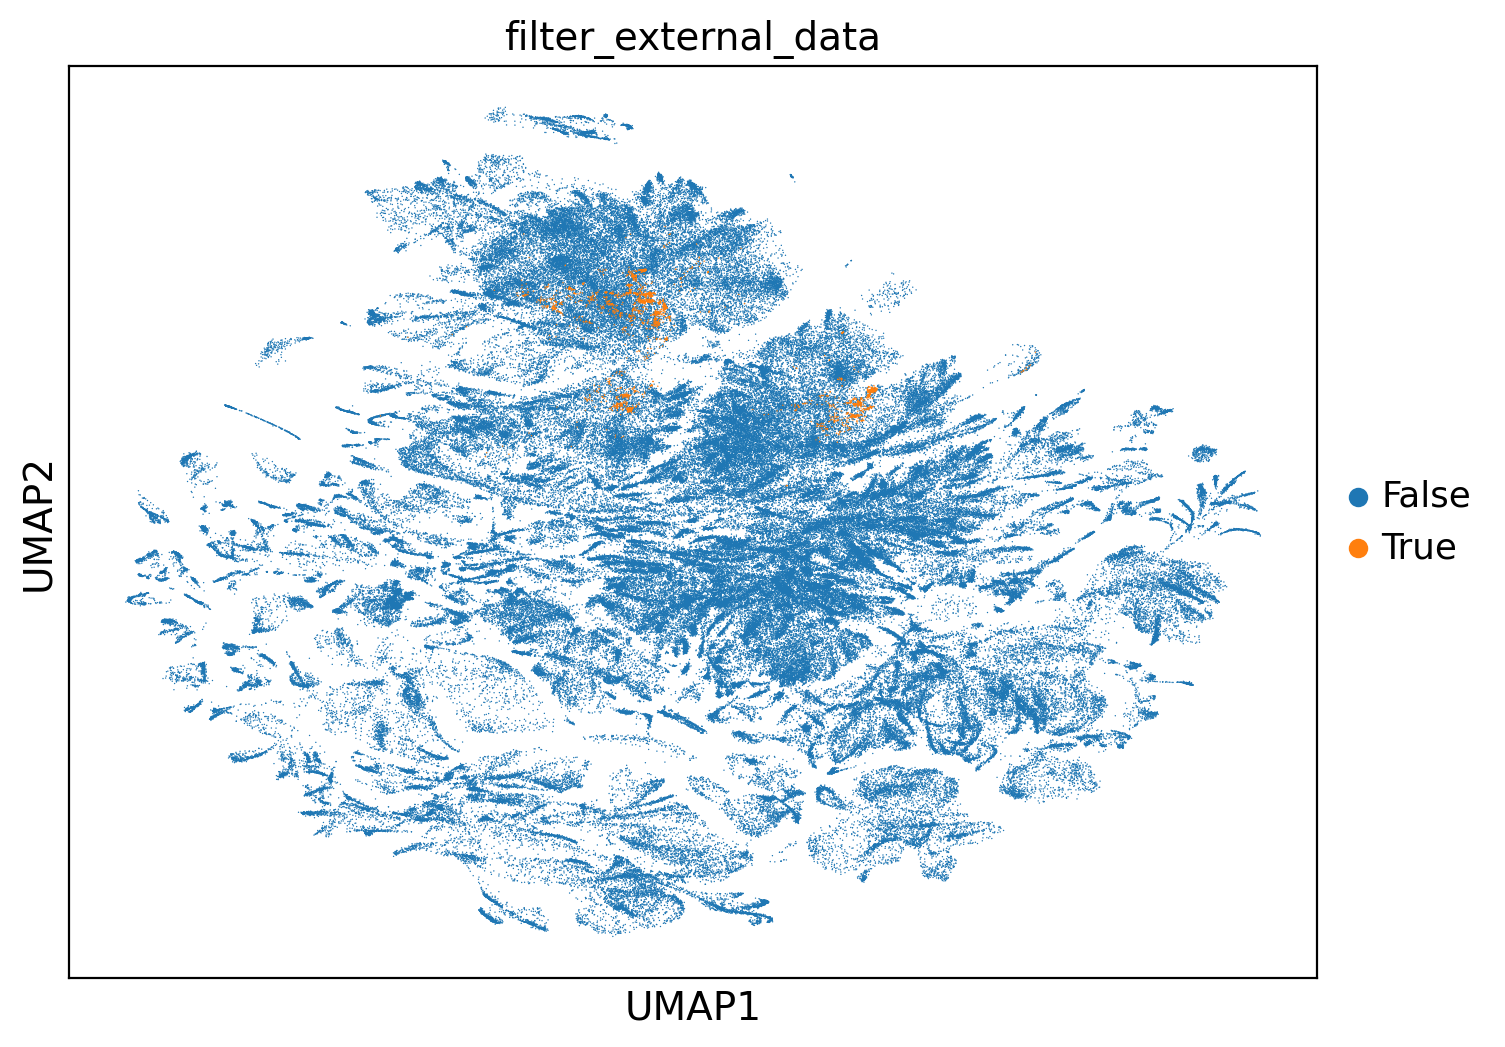

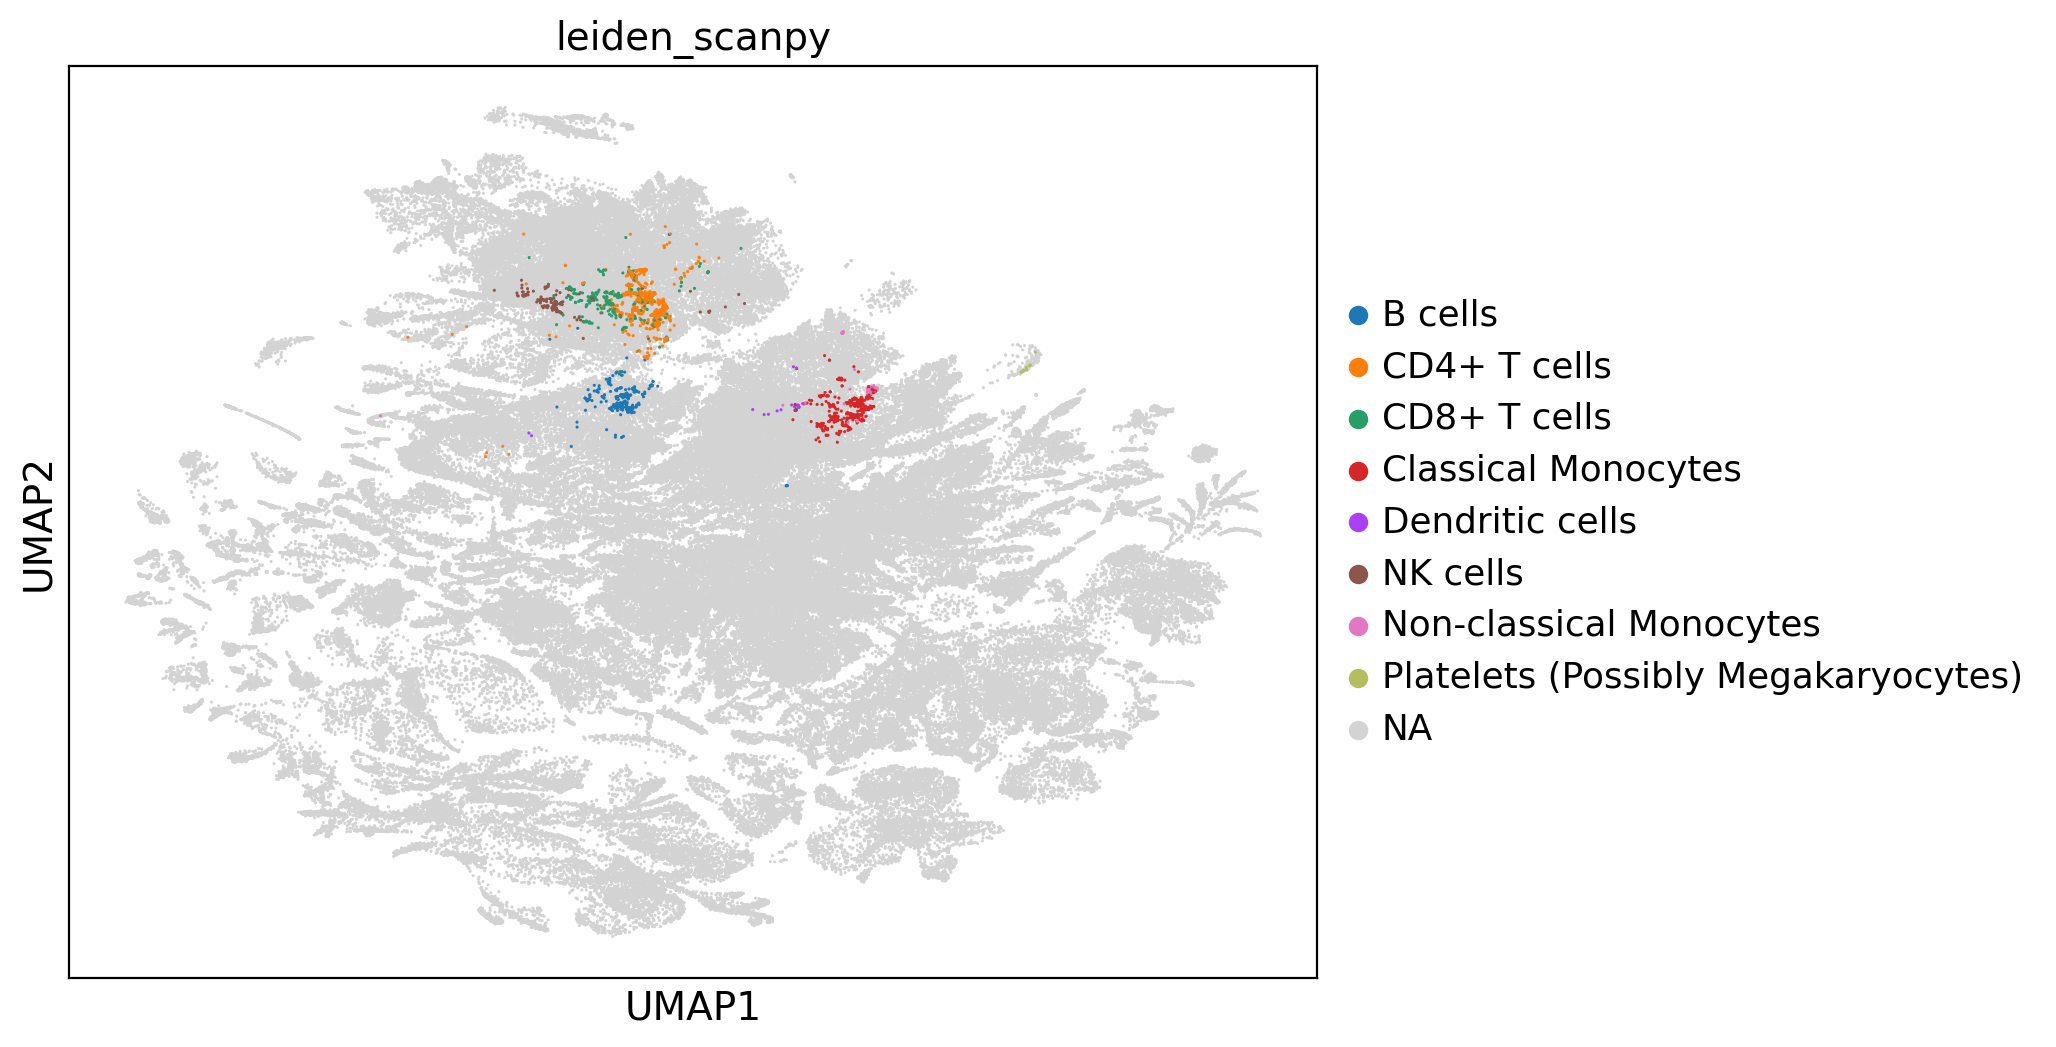

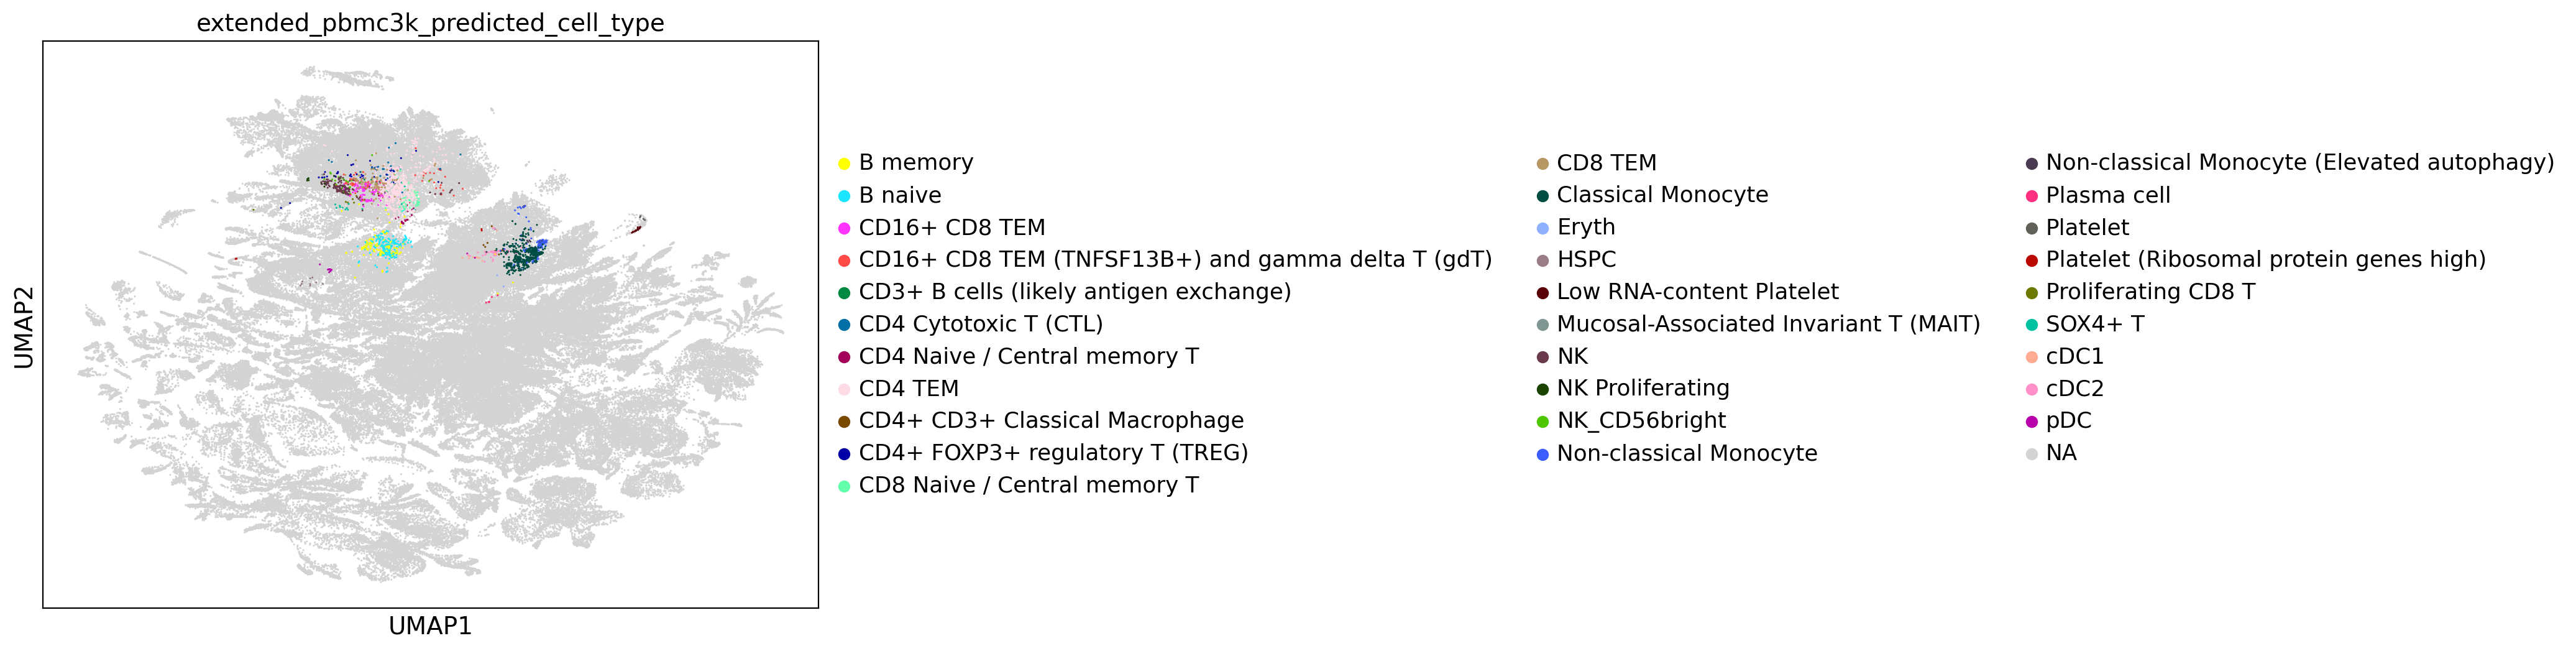

In [8]:
'''
set filter of the external data (dataset of interest)
'''
# set filter
ram.bc.filter = ( ram.bc.select_component( 0 ) & ram.bc.get_filter( f'filtered_barcodes_subsampled_{str_num_subsampled_cells}_entries_clus_info' ) ) | ( ram.bc.select_component( 1 ) & ram.bc.get_filter( name_col_bc_all ) )

ram.ft.load_str( )

# save as a filter
ram.bc.save_as_filter(
    ram.bc.select_component( 1 ) & ram.bc.get_filter( name_col_bc_all ),
    'filter_external_data'
)

"""
plot co-embedded cells
"""
# settings
# ram.int_index_component_reference = None # in order to retrieve gene expression data from ELDB, set index to the reference RamData to None (if ram.int_index_component_reference == 0, only PBMC3k dataset's count data will be retrieved)
ram.ft.filter = None # retrieve expression of any genes

# set filter
ram.bc.filter = ( ram.bc.select_component( 0 ) & ram.bc.get_filter( f'filtered_barcodes_subsampled_{str_num_subsampled_cells}_entries_clus_info' ) ) | ( ram.bc.select_component( 1 ) & ram.bc.get_filter( name_col_bc_all ) ) # for RamData-0 (ELDB), select the subsampled cells. for RamData-1 (PBMC3k), select all filtered cells

# define a list of genes of interest
dict_marker_genes = {
    'Proliferating' : [ 'MKI67' ],
    'T-cell' : [ 'CD3D' ],
    'CD4 T-cell' : [ 'CD4' ],
    'CD8 T-cell' : [ 'CD8A', 'CD8B' ],
    'Naive T / TCM' : [ 'CCR7', 'SELL' ],
    'Effector Phenotype' : [ 'FAS', 'CD44', 'IL2RG', 'IL7R', 'CD69' ],
    'TREG' : [ 'FOXP3', 'IL2RA' ], 
    'MAIT' : [ 'KLRB1', 'SLC4A10' ], 
    'SOX4+ CD4 T' : [ 'SOX4' ], 
    'gamma delta T' : [ 'TNFSF13B' ], 
    'NK' : [ 'GNLY', 'GZMB' ],
    'NK Recruiting (CD56 bright)' : [ 'XCL1', 'GZMK' ], 
    'B cell' : [ 'MS4A1', 'CD79A' ], 
    'B memory' : [ 'CD27' ],
    'Plasma cell' : [ 'JCHAIN', 'TXNDC5' ],
    'Monocyte' : [ 'CD86' ],
    'Classical Monocyte' : [ 'CD14' ], 
    'Non-classical Monocyte' : [ 'FCGR3A' ],
    'Macrophage' : [ 'CD68' ],
    'Macrophage (M1)' : [ 'CD86', 'FCGR2A', ], 
    'Macrophage (M2)' : [ 'CD163', 'MSR1' ], 
    'Dendritic' : [ 'FCER1A' ],
    "cDC1" : [ 'THBD', 'CLEC9A' ], 
    'cDC2' : [ 'CD1C', 'SIRPA' ], 
    'pDC' : [ 'CLEC4C', 'IL3RA', 'LILRA4' ], 
    'Platelet' : [ 'ITGA2B' ],
    'HPSC' : [ 'CD34' ],
}
l_marker_genes = [ ] # collect the marker genes
for e in dict_marker_genes :
    l_marker_genes += dict_marker_genes[ e ]

adata = ram[ 
    'normalized_log1p_capped', 
    :, 
    [ "str", 'raw_sum', 'filter_external_data', name_anno_predicted, name_anno_ori, { name_umap_combined } ], 
    l_marker_genes, 
    [ 'str' ]
] # for detailed descriptions, please see "Tutorial 1) Processing and analysis of the 3k PBMCs dataset using SC-Elephant.""
adata.obsm[ 'X_umap' ] = adata.obsm[ name_umap_combined ]
adata.obs[ 'filter_external_data' ] = adata.obs[ 'filter_external_data' ].astype( str ).astype( object )
    
sc.pl.umap( adata, color = 'filter_external_data', size = 1 )

"""
plot predicted annotations
"""   
sc.pl.umap( adata, color = name_anno_ori, size = 5 ) # cell types annotations from the Extended PBMC3k dataset
sc.pl.umap( adata, color = name_anno_predicted, size = 5 ) # cell types annotations from the Extended PBMC3k dataset

## Compare the deep-learning-based cell type annotations with the original annotations

In [9]:
"""
Compare original annotations and predicted annotations using a deep-learning model from ELDB
"""
def Shankey_Compare_Annotations( l_anno_1, l_anno_2, int_min_num_entries_for_an_overlap : int = 3, flag_show_label : bool = True, font_size : int = 10, title : str = '', dict_color : dict = dict( ), fig_height : int = 850 ) :
    """ # 2023-03-05 16:32:49 
    draw a Shankey diagram using Plotly for the given lists of annotations
    
    l_anno_1 # first list of annotations 
    l_anno_2 # second list of annotations 
    int_min_num_entries_for_an_overlap : int = 3 # the minmum number of entries for a link (overlaps between two annotations) to be valid.
    title : Union[ None, str ] = None # the name of the figure. if None is given, no title will be shown
    font_size : int = 10, # the font size of the title
    dict_color : dict = dict( ), # name of the label to color mapping
    fig_height # height of the output graph 
    """
    import numpy as np
    def _map( arr_anno, start_pos : int = 0 ) :
        """
        return a dictionary for mapping annotation to its integer representation and a list of unique annotation labels
        """
        l_anno_unique = el.bk.LIST_COUNT( arr_anno, duplicate_filter = None ).index.values # retrieve a list of unique annotations
        return dict( ( e, i + start_pos ) for i, e in enumerate( l_anno_unique ) ), l_anno_unique

    dict_map_1, arr_anno_unique_1 = _map( l_anno_1, start_pos = 0 )
    dict_map_2, arr_anno_unique_2 = _map( l_anno_2, start_pos = len( dict_map_1 ) )
    label = list( arr_anno_unique_1 ) + list( arr_anno_unique_2 ) if flag_show_label else None # compose a list of unique labels # does not show labels if 'flag_show_label' is False

    # retrieve values for drawing the diagram
    source, target, value = el.bk.LIST_COUNT( np.array( [ list( dict_map_1[ e ] for e in l_anno_1 ), list( dict_map_2[ e ] for e in l_anno_2 ) ], dtype = int ).T, duplicate_filter = int_min_num_entries_for_an_overlap ).reset_index( drop = False ).values.T
    # compose a dataframe
    
    # draw a plot
    import plotly.graph_objects as go

    fig = go.Figure( data = [ go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict( color = "black", width = 0.5 ),
          label = label,
          color = list( dict_color[ e ] if e in dict_color else 'blue' for e in label ),
        ),
        link = dict(
          source = source, 
          target = target,
          value = value
      ))])
    if title is not None :
        fig.update_layout( title_text = title, font_size = font_size, height = fig_height )
    return fig
def Get_dict_color( adata, name_col : str ) :
    ''' get name_category > color mapping of a given column in the .obs of a given AnnData '''
    try :
        return dict( ( n, c ) for n, c in zip( adata.obs[ name_col ].cat.categories, adata.uns[ name_col + '_colors' ] ) )
    except :
        return dict( )
    
# define the folder containing the data
path_folder_graph = f'output/graph/'
os.makedirs( path_folder_graph, exist_ok = True ) # create the output folder

# cell types annotations from the Extended PBMC3k dataset
l_anno_1, l_anno_2 = adata.obs.loc[ adata.obs[ 'filter_external_data' ] == 'True', [ name_anno_ori, name_anno_predicted ] ].values.T
fig = Shankey_Compare_Annotations( l_anno_1, l_anno_2, int_min_num_entries_for_an_overlap = 3, flag_show_label = True, title = name_anno_predicted, dict_color = { ** Get_dict_color( adata, name_anno_ori ), ** Get_dict_color( adata, name_anno_predicted ) } )
fig.show( )
fig.write_html( f"{path_folder_graph}plotly.shankey_comparison.{name_anno_ori}.{name_anno_predicted}.html" )

## Analysis of PBMC-3k dataset using the detailed annotations, predicted using the model from ELDB

... storing 'extended_pbmc3k_predicted_cell_type_with_numbers' as categorical


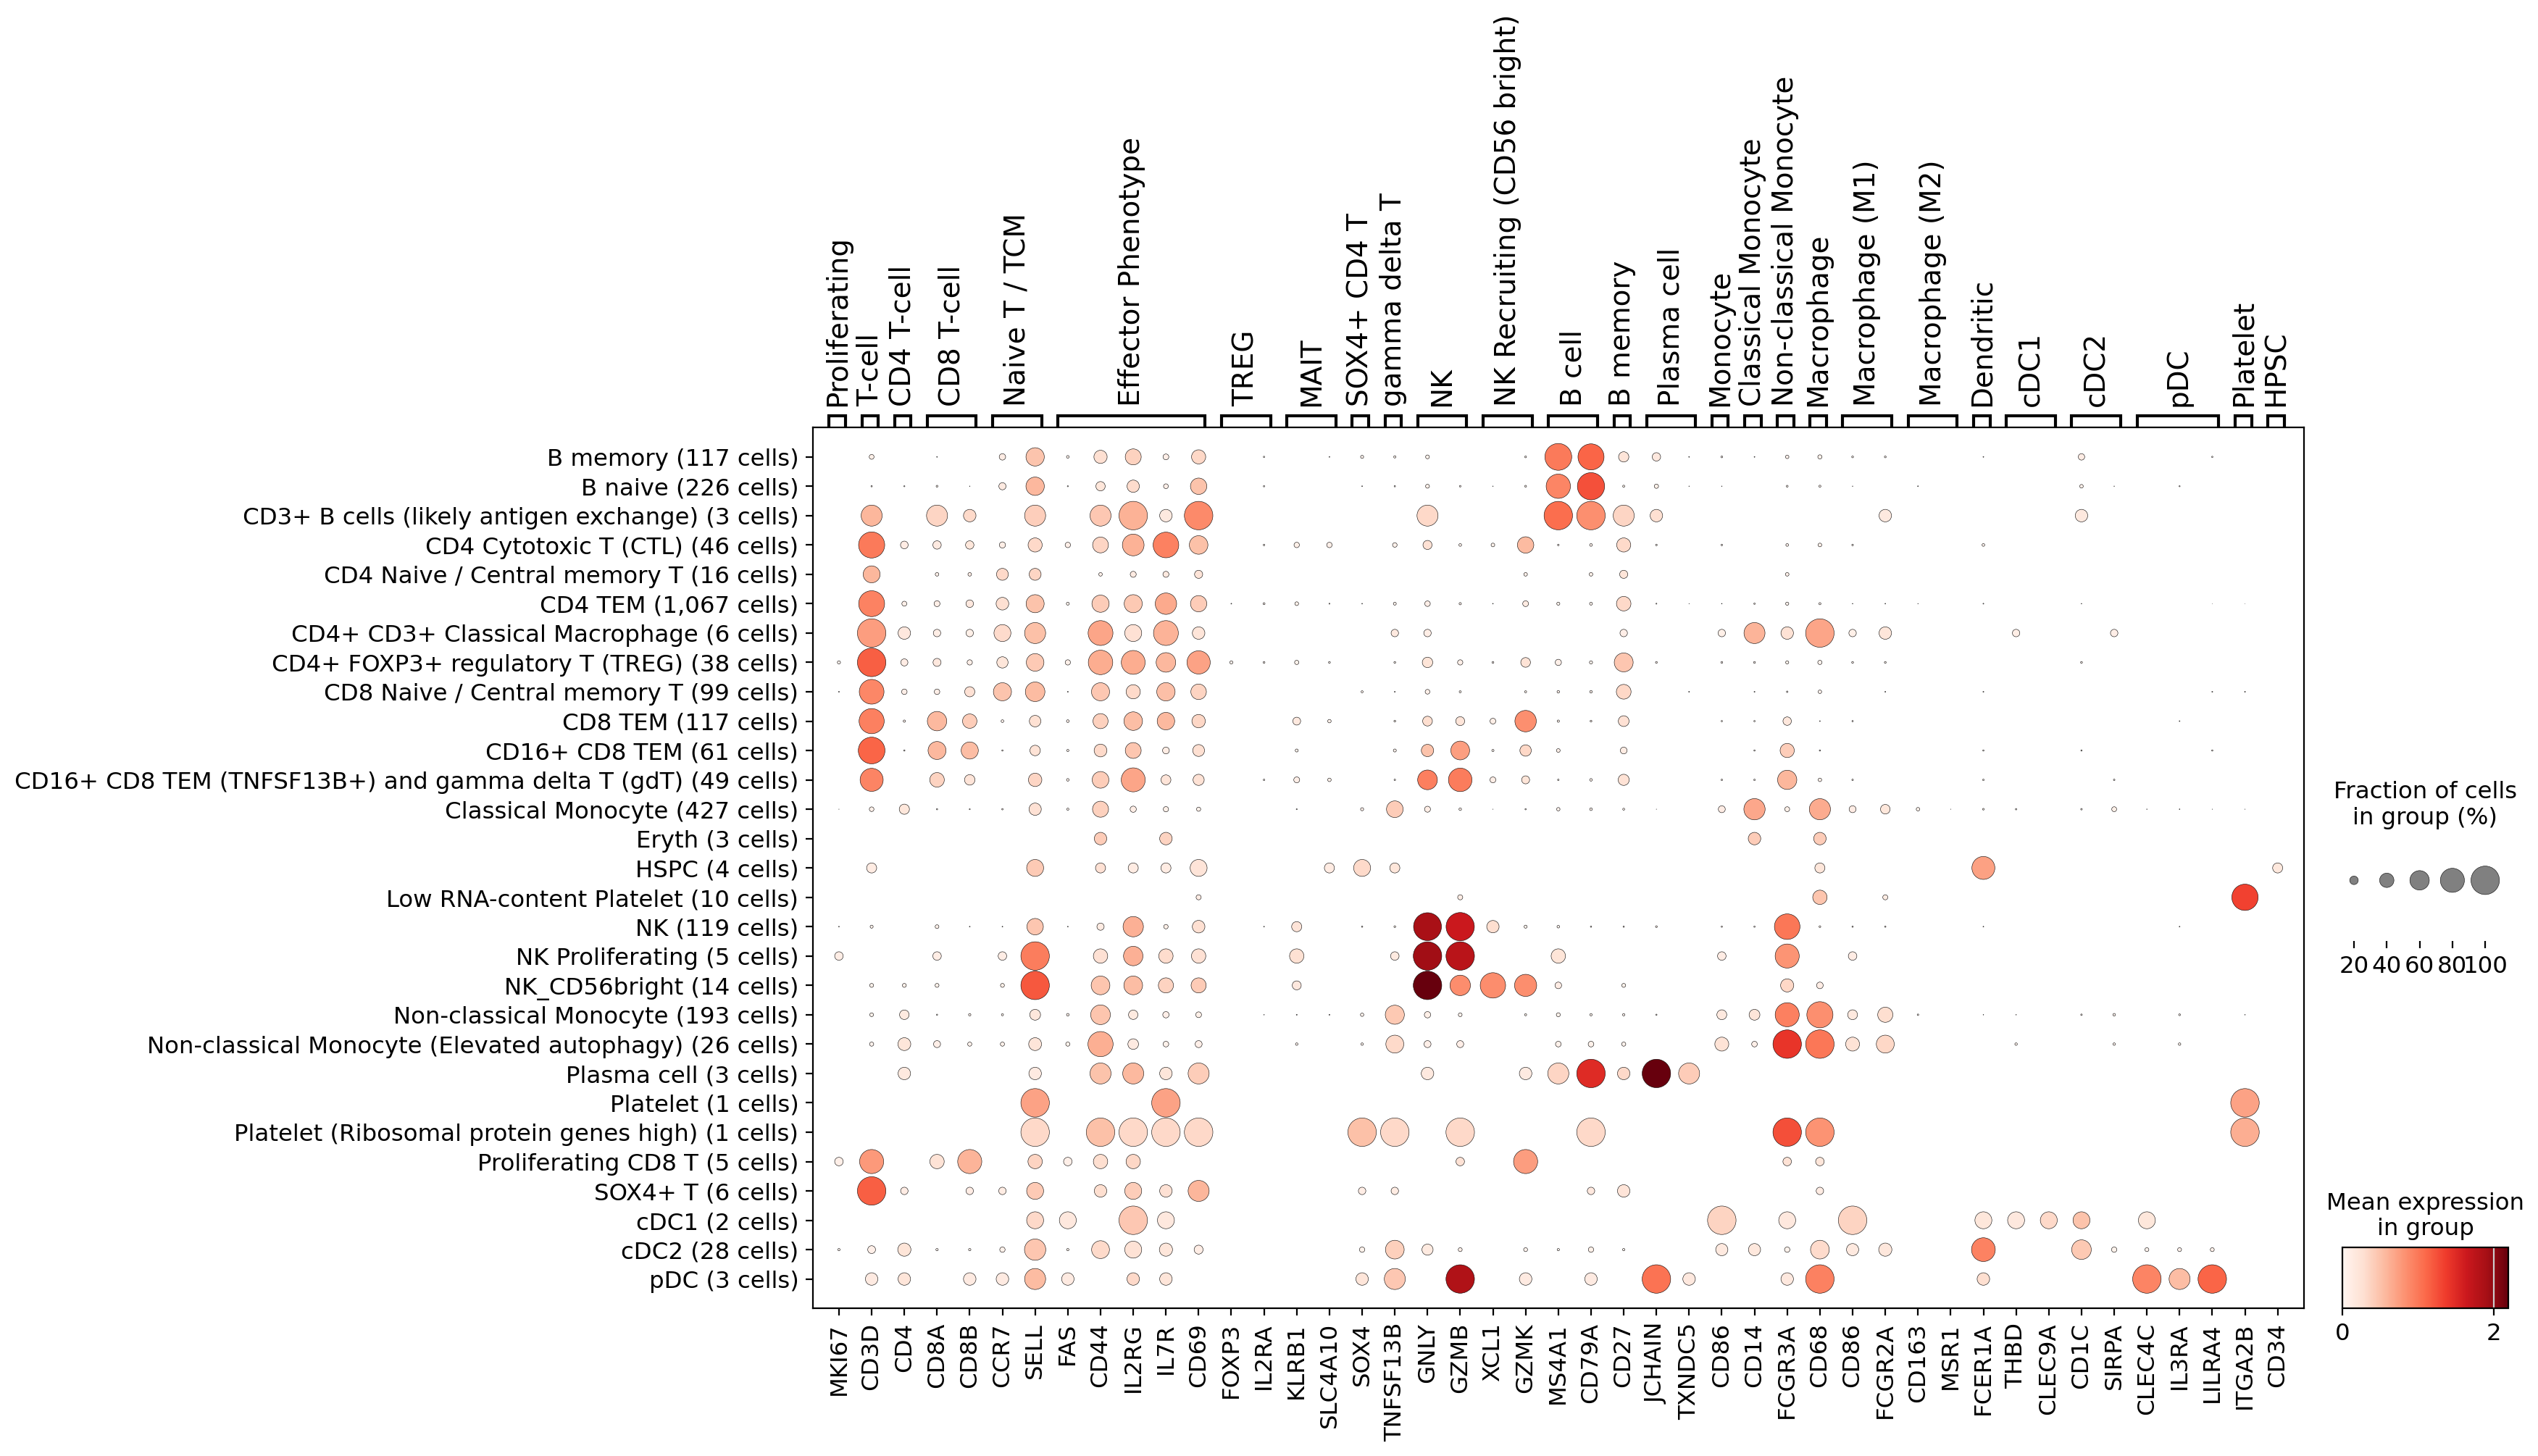

In [31]:
''' subset PBMC 3k dataset '''
# select only the cells of the PBMC 3k dataset
adata_subset = adata[ adata.obs.filter_external_data == 'True' ] 

# add the number of 'PBMC 3k' cells predicted to each cell type label
dict_mapping = dict( ( e, f"{e} ({c:,} cells)" ) for e, c in el.bk.LIST_COUNT( adata_subset.obs[ name_anno_predicted ], duplicate_filter = None ).reset_index( ).values ) 
name_anno_predicted_for_plotting = f"{name_anno_predicted}_with_numbers"
adata_subset.obs[ name_anno_predicted_for_plotting ] = list( dict_mapping[ e ] for e in adata_subset.obs[ name_anno_predicted ].values )

''' show dotplot '''
sc.pl.dotplot( adata_subset, dict_marker_genes, groupby = name_anno_predicted_for_plotting, figsize = ( 15, 8 ) ) # draw a dot plot using the count data of the PBMC 3k dataset

## **View a Combined RamData (after the analysis)** 
- JavaScript-based interactive visualization of 'Combined' RamData object in Jupyter Notebook

In [32]:
ram

<RamData object (262431/322700 barcodes X 62914 features, 690161292 records in the currently active layer 'normalized_log1p_capped') stored at /home/merit_an/git/scelephant/doc/jn/tutorials/output/pbmc3k.combined_with_eldb.v20221214.aws.subset_320000.ram/
	with the following layers : {'normalized', 'raw', 'normalized_log1p', 'normalized_log1p_capped'}
		current layer is 'normalized_log1p_capped'>